# Clustering 3k PBMCs following a Seurat Tutorial

This started out (May 2017) with a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) clustering tutorial ([link](http://satijalab.org/seurat/pbmc3k_tutorial.html)), which we gratefully acknowledge. In the meanwhile, we have added and removed several pieces.

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [424]:
import numpy as np
import pandas as pd
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './pbmc3k.h5ad'

scanpy==1.3.6 anndata==0.6.16 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [425]:
sc.settings.set_figure_params(dpi=80)

In [426]:
adata = sc.read_10x_mtx(
    '/Users/tfriedrich/Box Sync/laptop_folders/ihg-client.ucsf.edu/willenbringh/FC_102418_analysis/filtered_gene_bc_matrices/mm10/', var_names='gene_symbols', cache=True)

... reading from cache file ./cache/Users-tfriedrich-Box Sync-laptop_folders-ihg-client.ucsf.edu-willenbringh-FC_102418_analysis-filtered_gene_bc_matrices-mm10-matrix.h5ad


In [427]:
adata.var_names_make_unique()

## Preprocessing

**Note:** In notebooks and jupyter lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

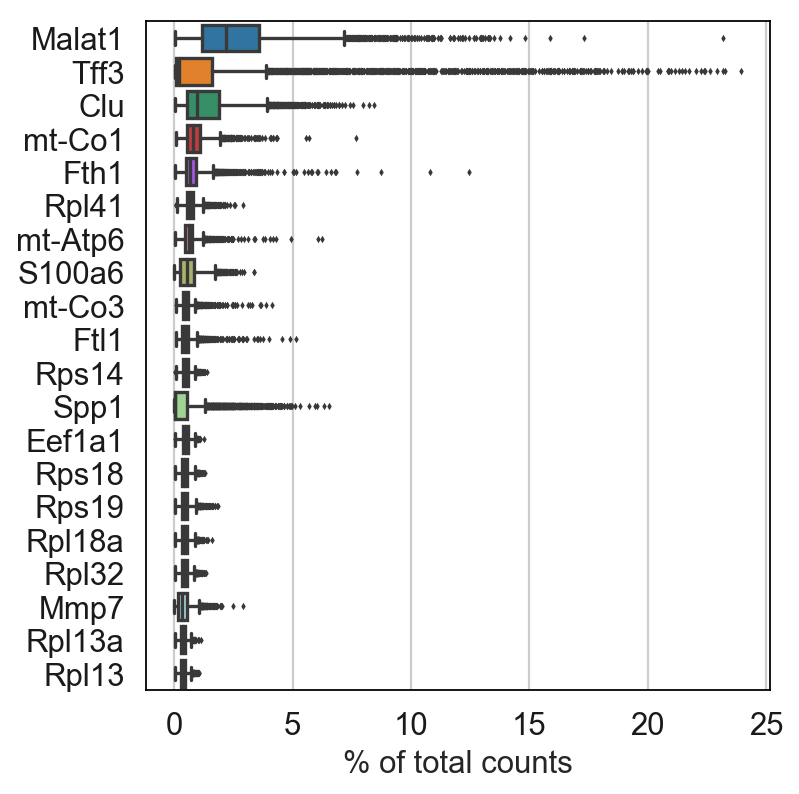

In [428]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering.

In [429]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 10646 genes that are detected in less than 3 cells


Plot some information about mitochondrial genes, important for quality control. Note that you can also retrieve mitochondrial genes using `sc.queries.mitochondrial_genes_biomart('www.ensembl.org', 'mmusculus')`.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):
> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

Note you can also use the function `pp.calculate_qc_metrics` to computes this and more.

In [430]:
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

A violin plot of the computed quality measures.

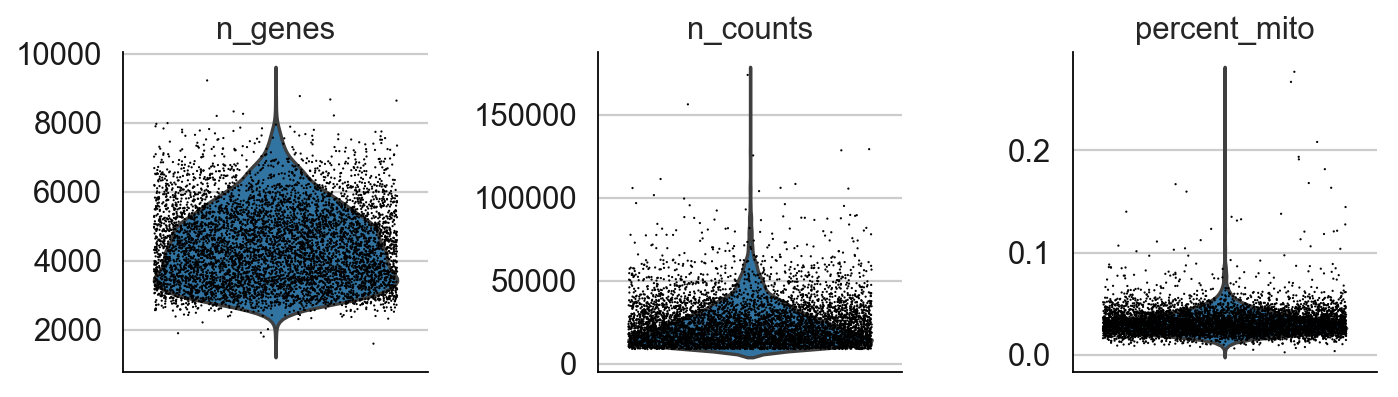

In [431]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

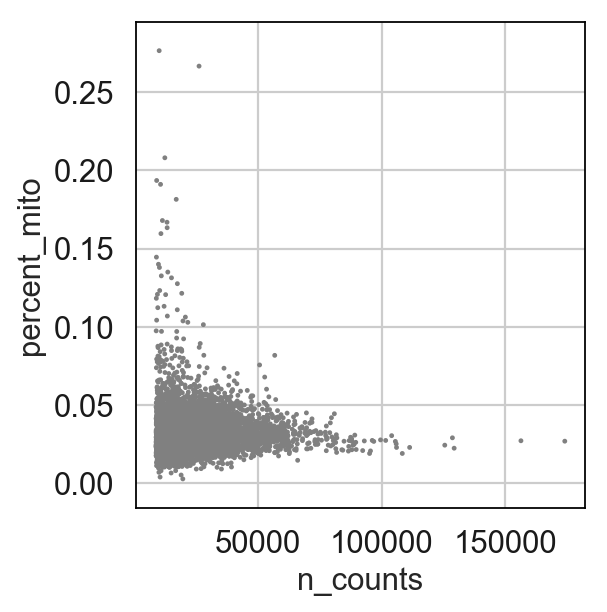

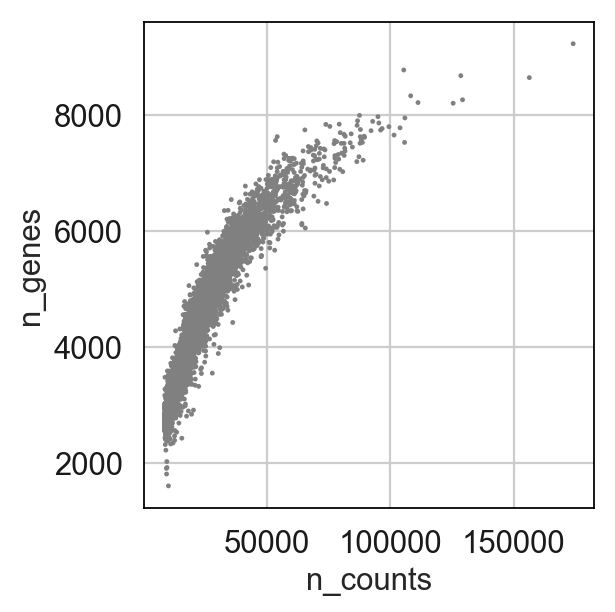

In [432]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [433]:
adata

AnnData object with n_obs × n_vars = 6344 × 17352 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

Actually do the filtering.

In [434]:
#adata = adata[adata.obs['n_genes'] < 8000, :]
#adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [435]:
adata

AnnData object with n_obs × n_vars = 6344 × 17352 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

Per-cell normalize (library-size correct) the data matrix $\mathbf{X}$, so that counts become comparable among cells.

In [436]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Logarithmize the data.

In [437]:
sc.pp.log1p(adata)

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data.

In [438]:
adata.raw = adata

Identify highly-variable genes.

In [439]:
sc.pp.highly_variable_genes

<function scanpy.preprocessing.highly_variable_genes.highly_variable_genes(adata, min_disp=None, max_disp=None, min_mean=None, max_mean=None, n_top_genes=None, n_bins=20, flavor='seurat', subset=False, inplace=True)>

In [440]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', boolean vector (adata.var)
    'dispersions', boolean vector (adata.var)
    'dispersions_norm', boolean vector (adata.var)


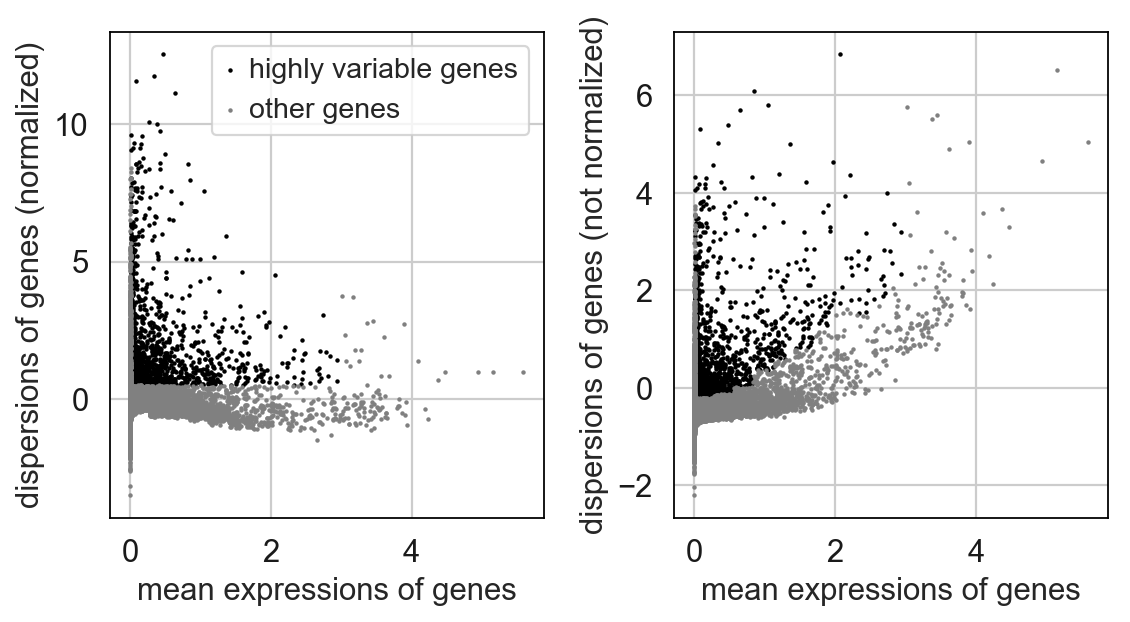

In [441]:
sc.pl.highly_variable_genes(adata)

Actually do the filtering.


In [442]:
#adata.var['highly_variable']

In [445]:
len(adata.var['highly_variable'] == True)

17352

In [446]:
#adata = adata[:, adata.var['highly_variable']]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [447]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:01:26.11)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [448]:
sc.pp.scale(adata, max_value=10)

Save the result.

In [449]:
adata 

AnnData object with n_obs × n_vars = 6344 × 17352 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [450]:

adata.write(results_file)

## PCA

Compute PCA and make a scatter plot.

In [451]:
sc.tl.pca(adata, svd_solver='arpack')

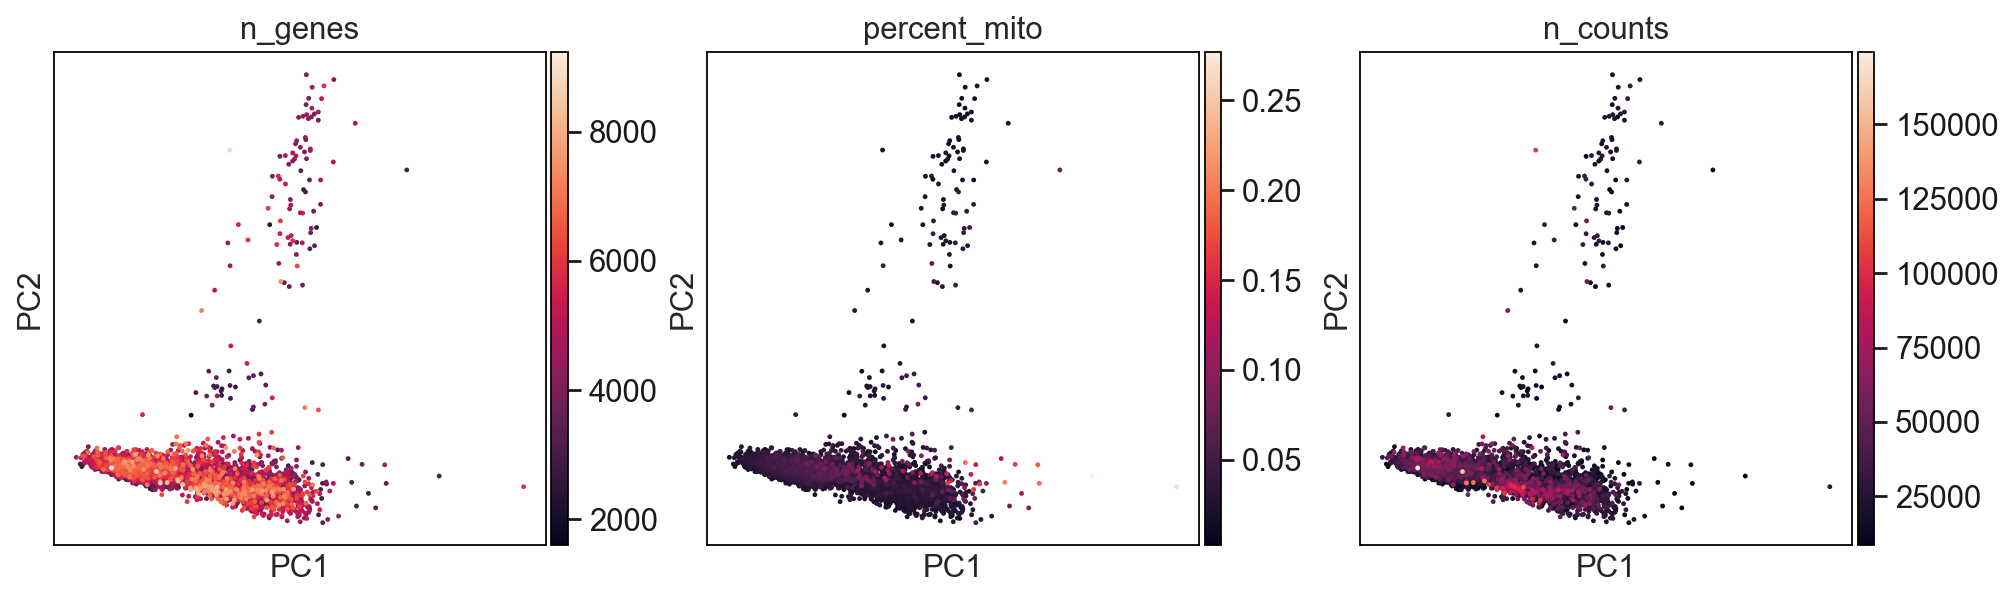

In [452]:
sc.pl.pca(adata, color=['n_genes', 'percent_mito', 'n_counts'])

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

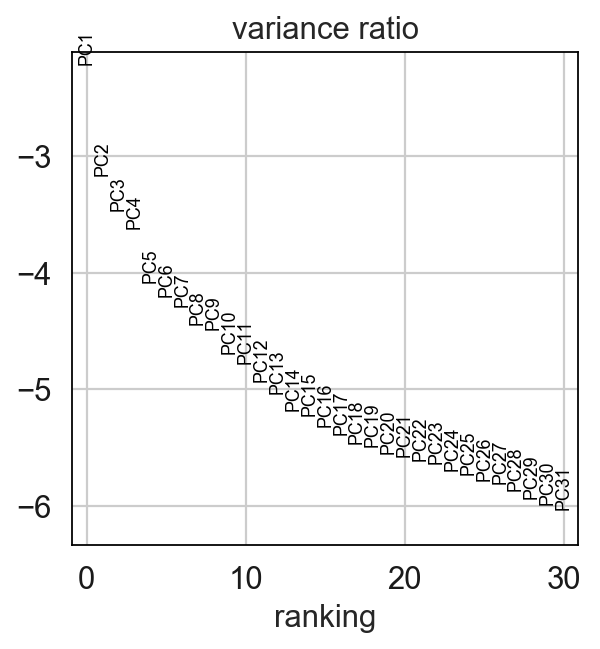

In [457]:
sc.pl.pca_variance_ratio(adata, log=True)

In [458]:
adata.write(results_file)

In [459]:
adata

AnnData object with n_obs × n_vars = 6344 × 17352 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

In [460]:
adata = sc.read(results_file)

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

#warning is ok for now: https://github.com/lmcinnes/umap/issues/87

In [461]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


/Users/tfriedrich/miniconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:01.93) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


We now advertise visualizing the data using UMAP, see below. In particular, if you have large data, this will give you a notable speedup. Also, it is potentially more faithful to global topology: trajectories are better preserved.

In [469]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:51.01) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


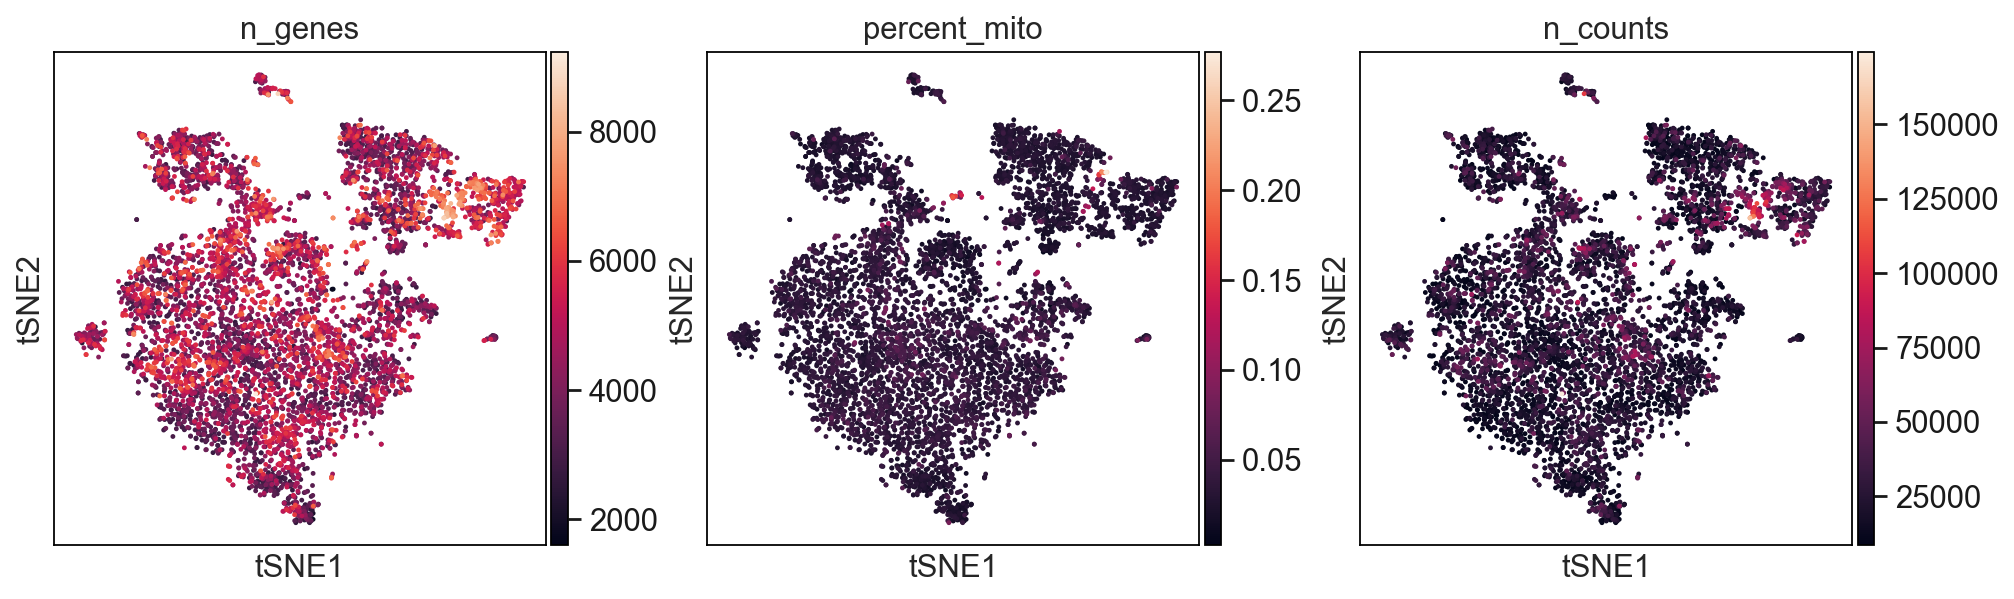

In [470]:
sc.pl.tsne(adata, color=['n_genes', 'percent_mito', 'n_counts'])

As we set the `.raw` attribute of AnnData (a "frozen" state of the object at a point in the pipeline where we deemed the data "raw"), the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

In [471]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:06.25) --> added
    'X_umap', UMAP coordinates (adata.obsm)


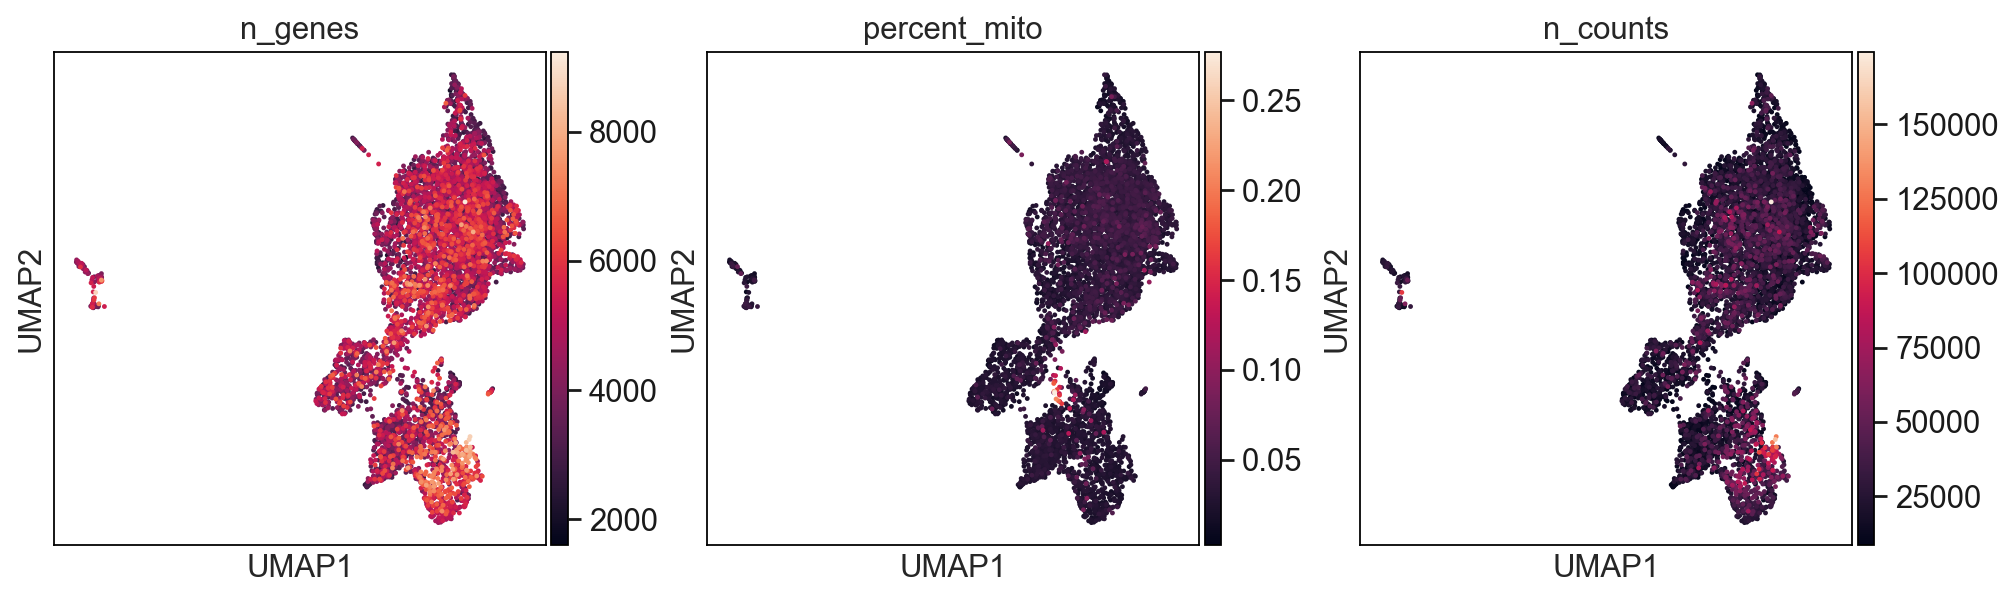

In [472]:
sc.pl.umap(adata, color=['n_genes', 'percent_mito', 'n_counts'], use_raw=False)

## Clustering the graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine *et al.* (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [473]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.84) --> found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Plot the data with tSNE. Coloring according to clustering. Clusters agree quite well with the result of Seurat.

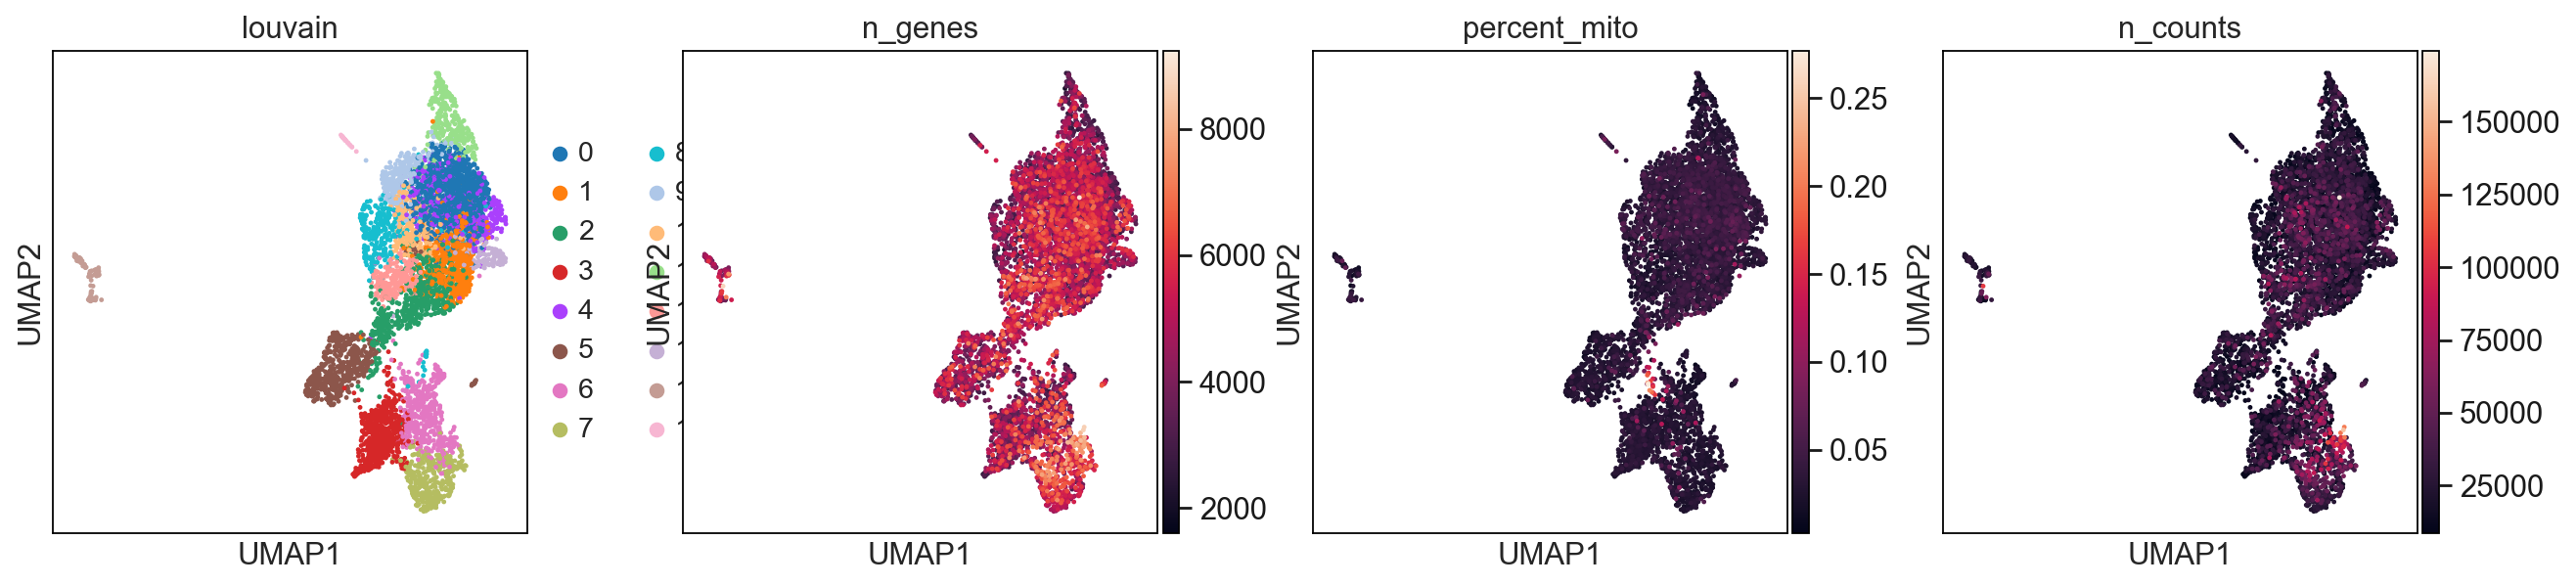

In [474]:
sc.pl.umap(adata, color=['louvain', 'n_genes', 'percent_mito', 'n_counts'])

In [475]:
adata.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished (0:00:14.75) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


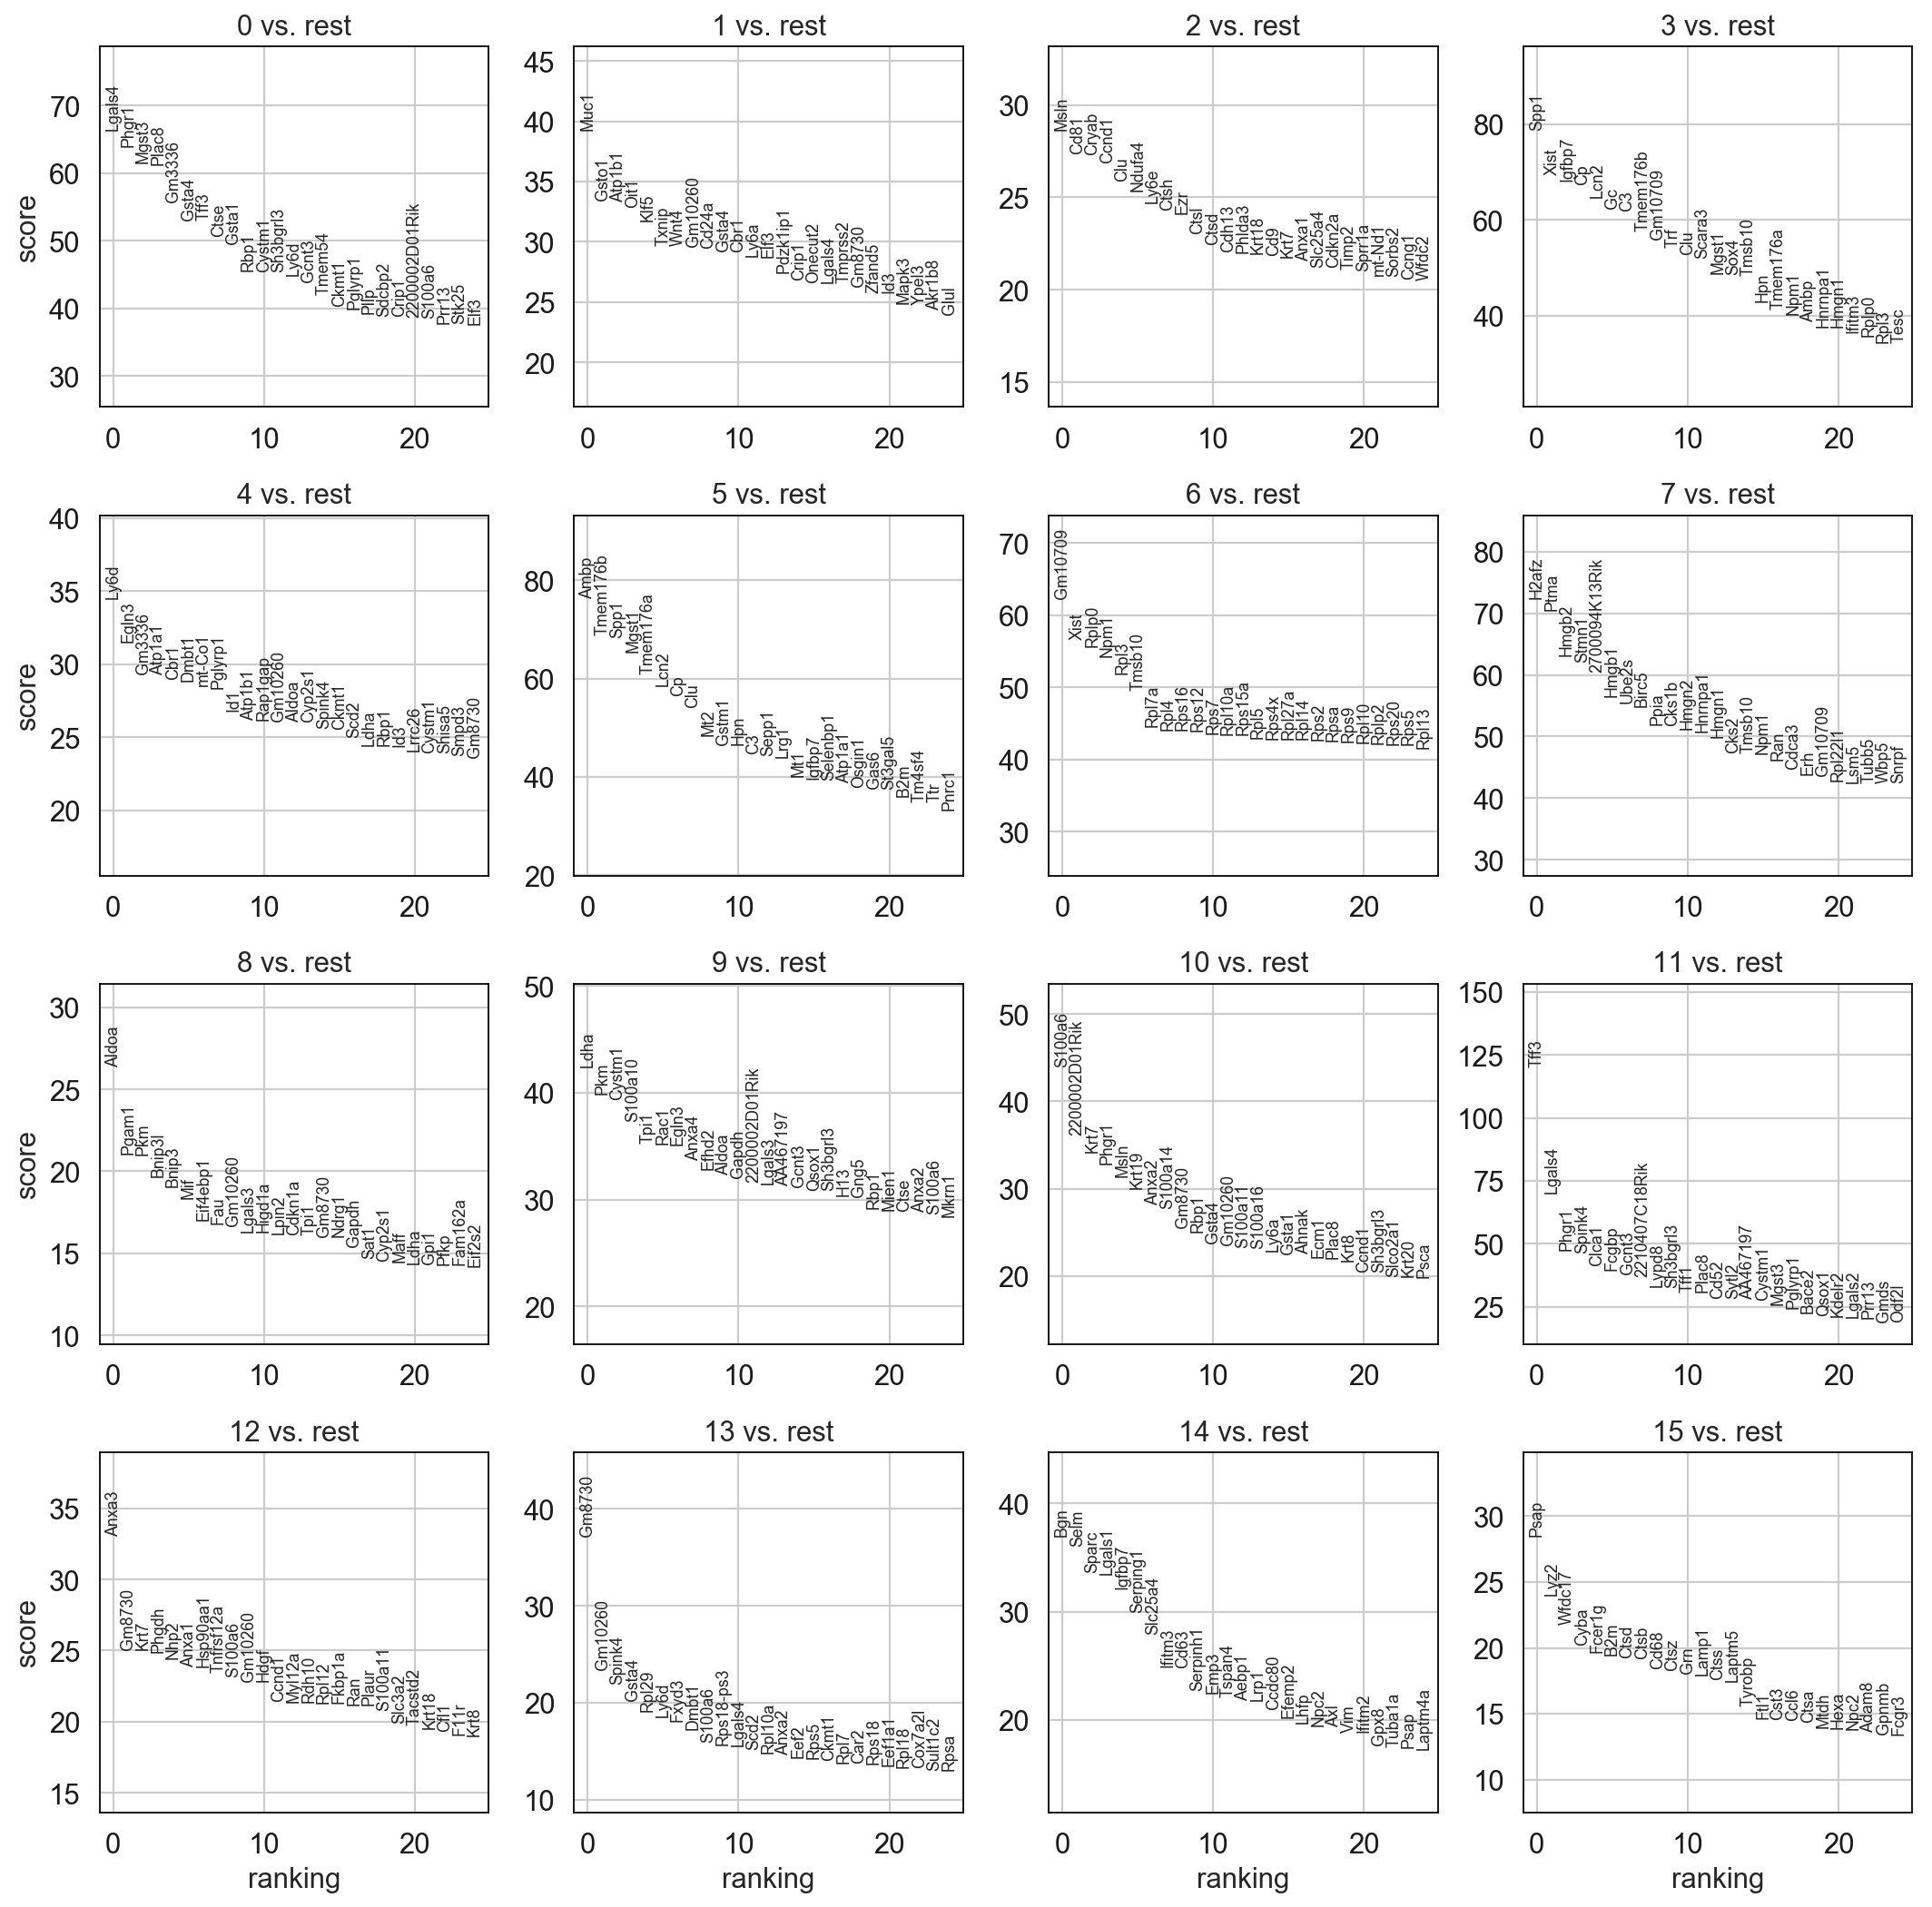

In [476]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [477]:
adata

AnnData object with n_obs × n_vars = 6344 × 17352 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [478]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar.

ranking genes
    finished (0:00:24.08)


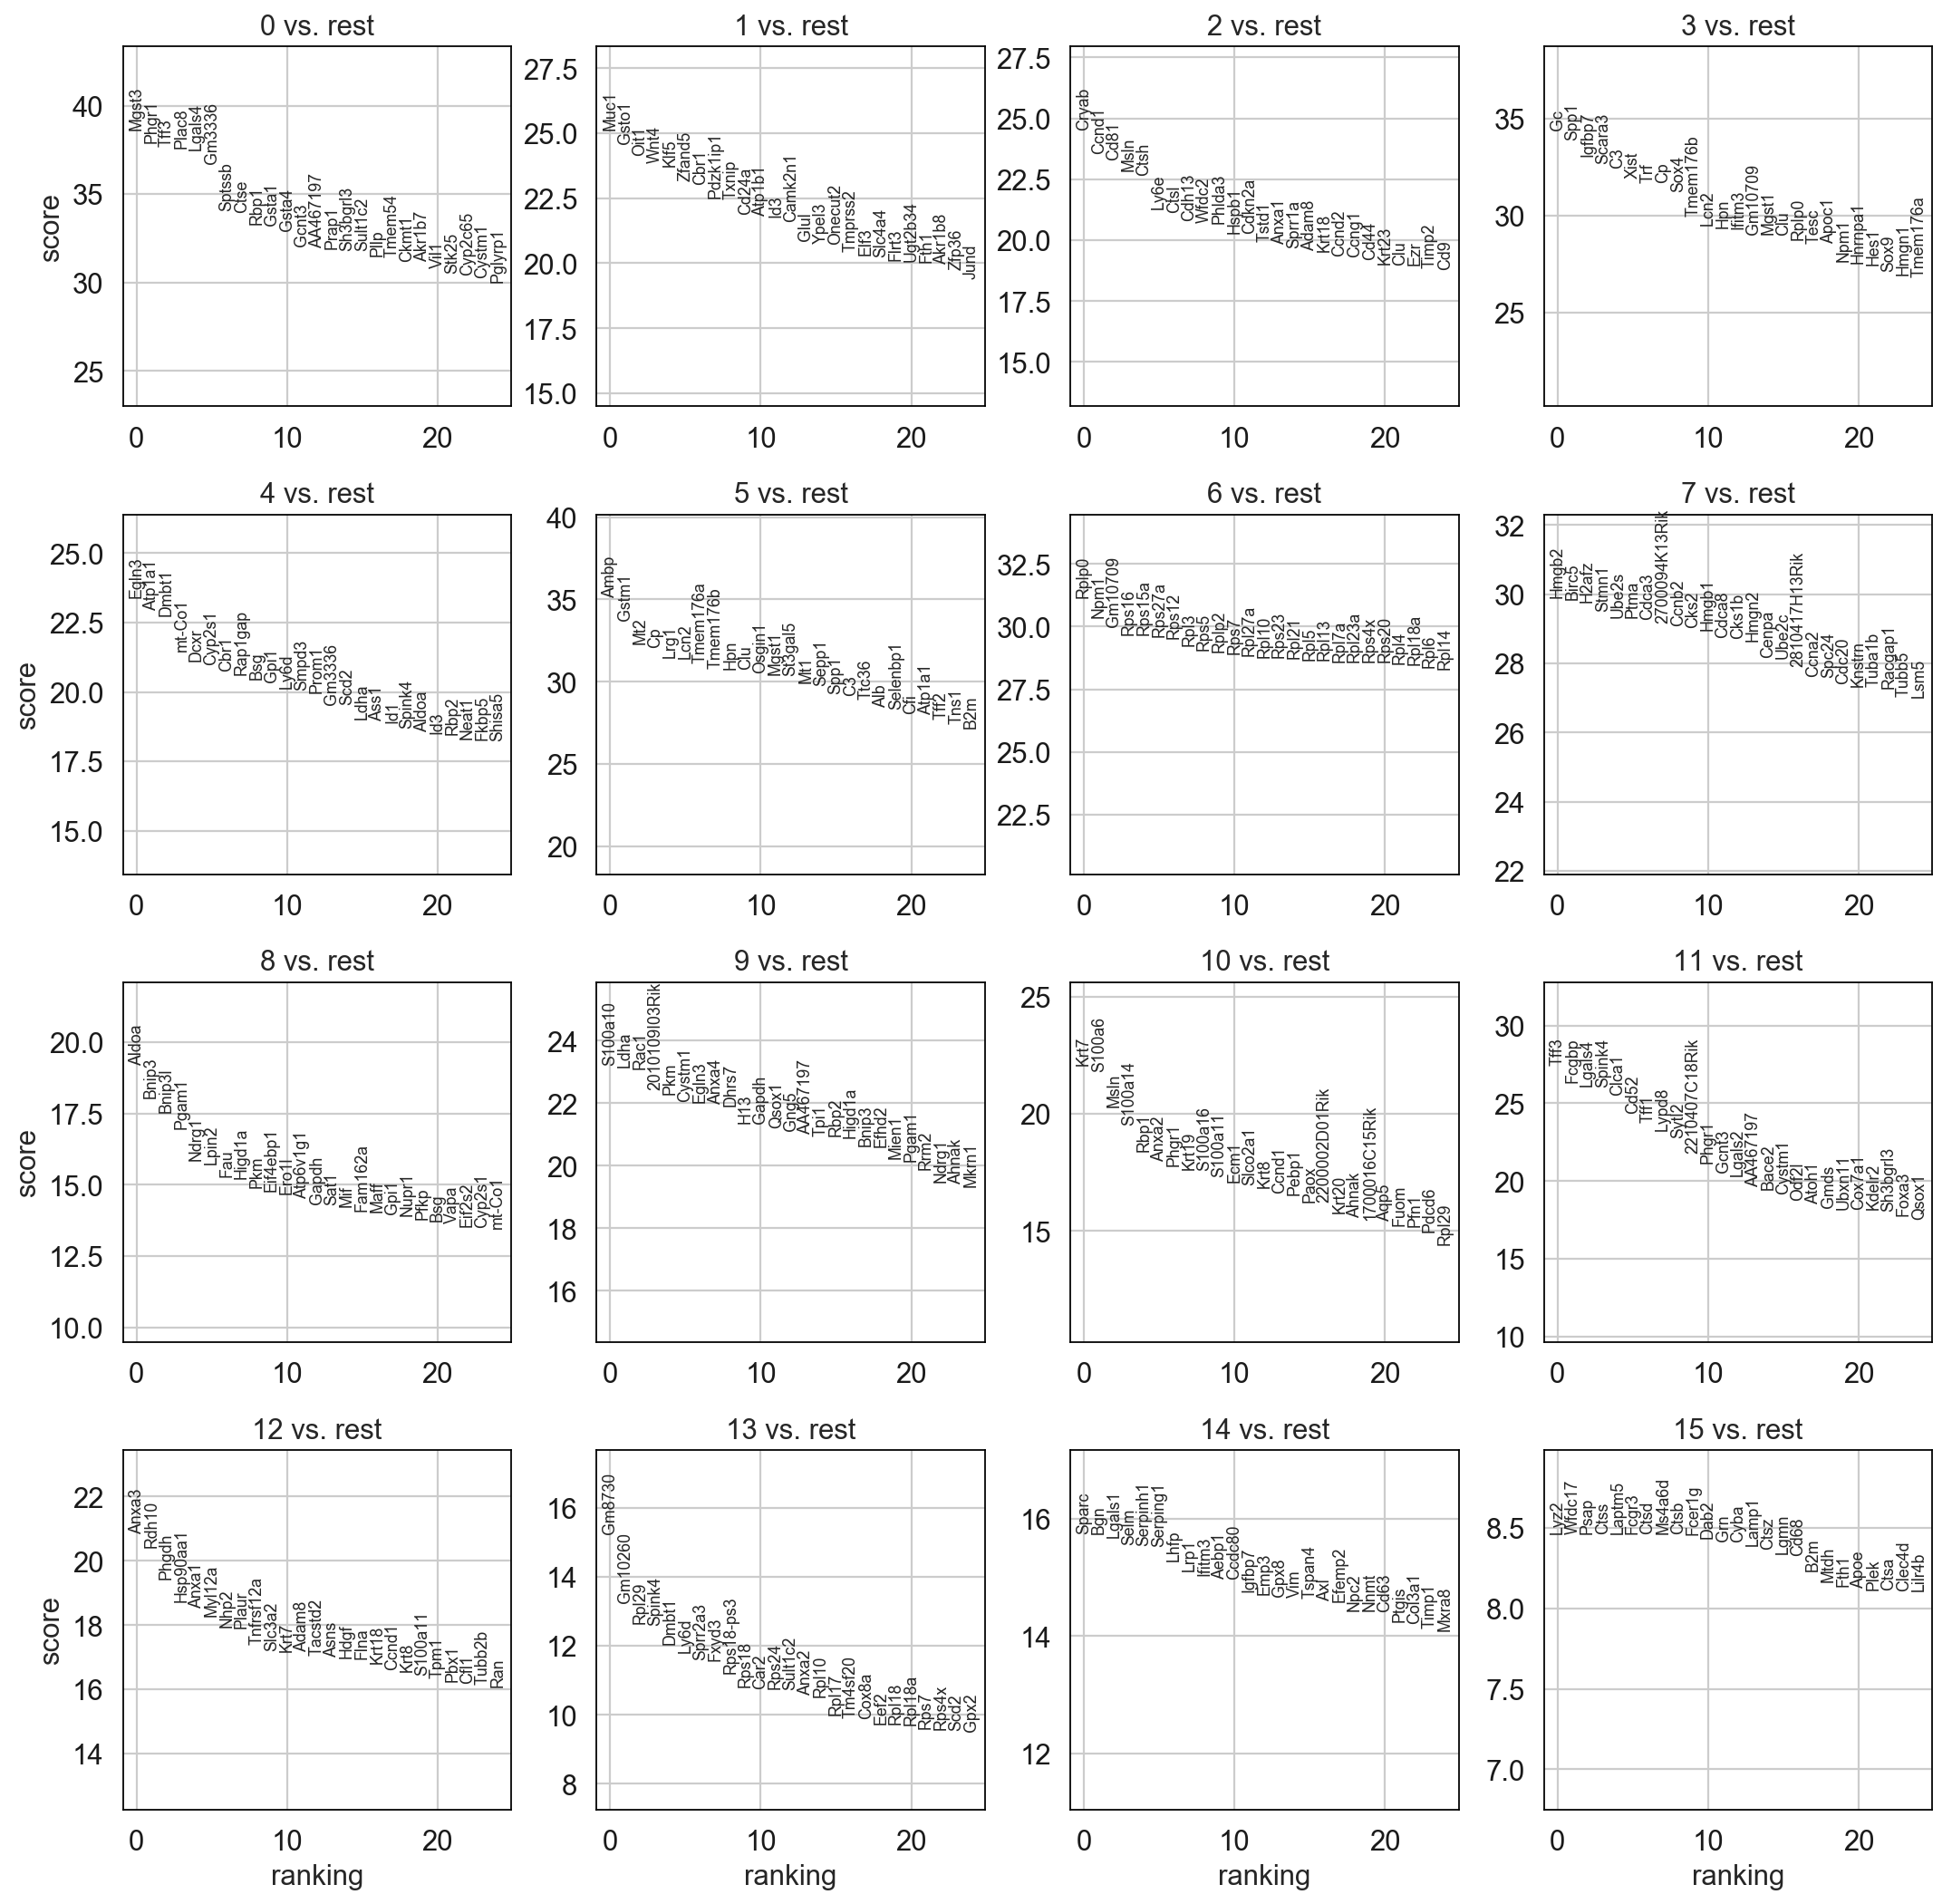

In [480]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [394]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos *et al.* (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark *et al.* (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes


/Users/tfriedrich/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tfriedrich/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


    finished (0:01:21.86)


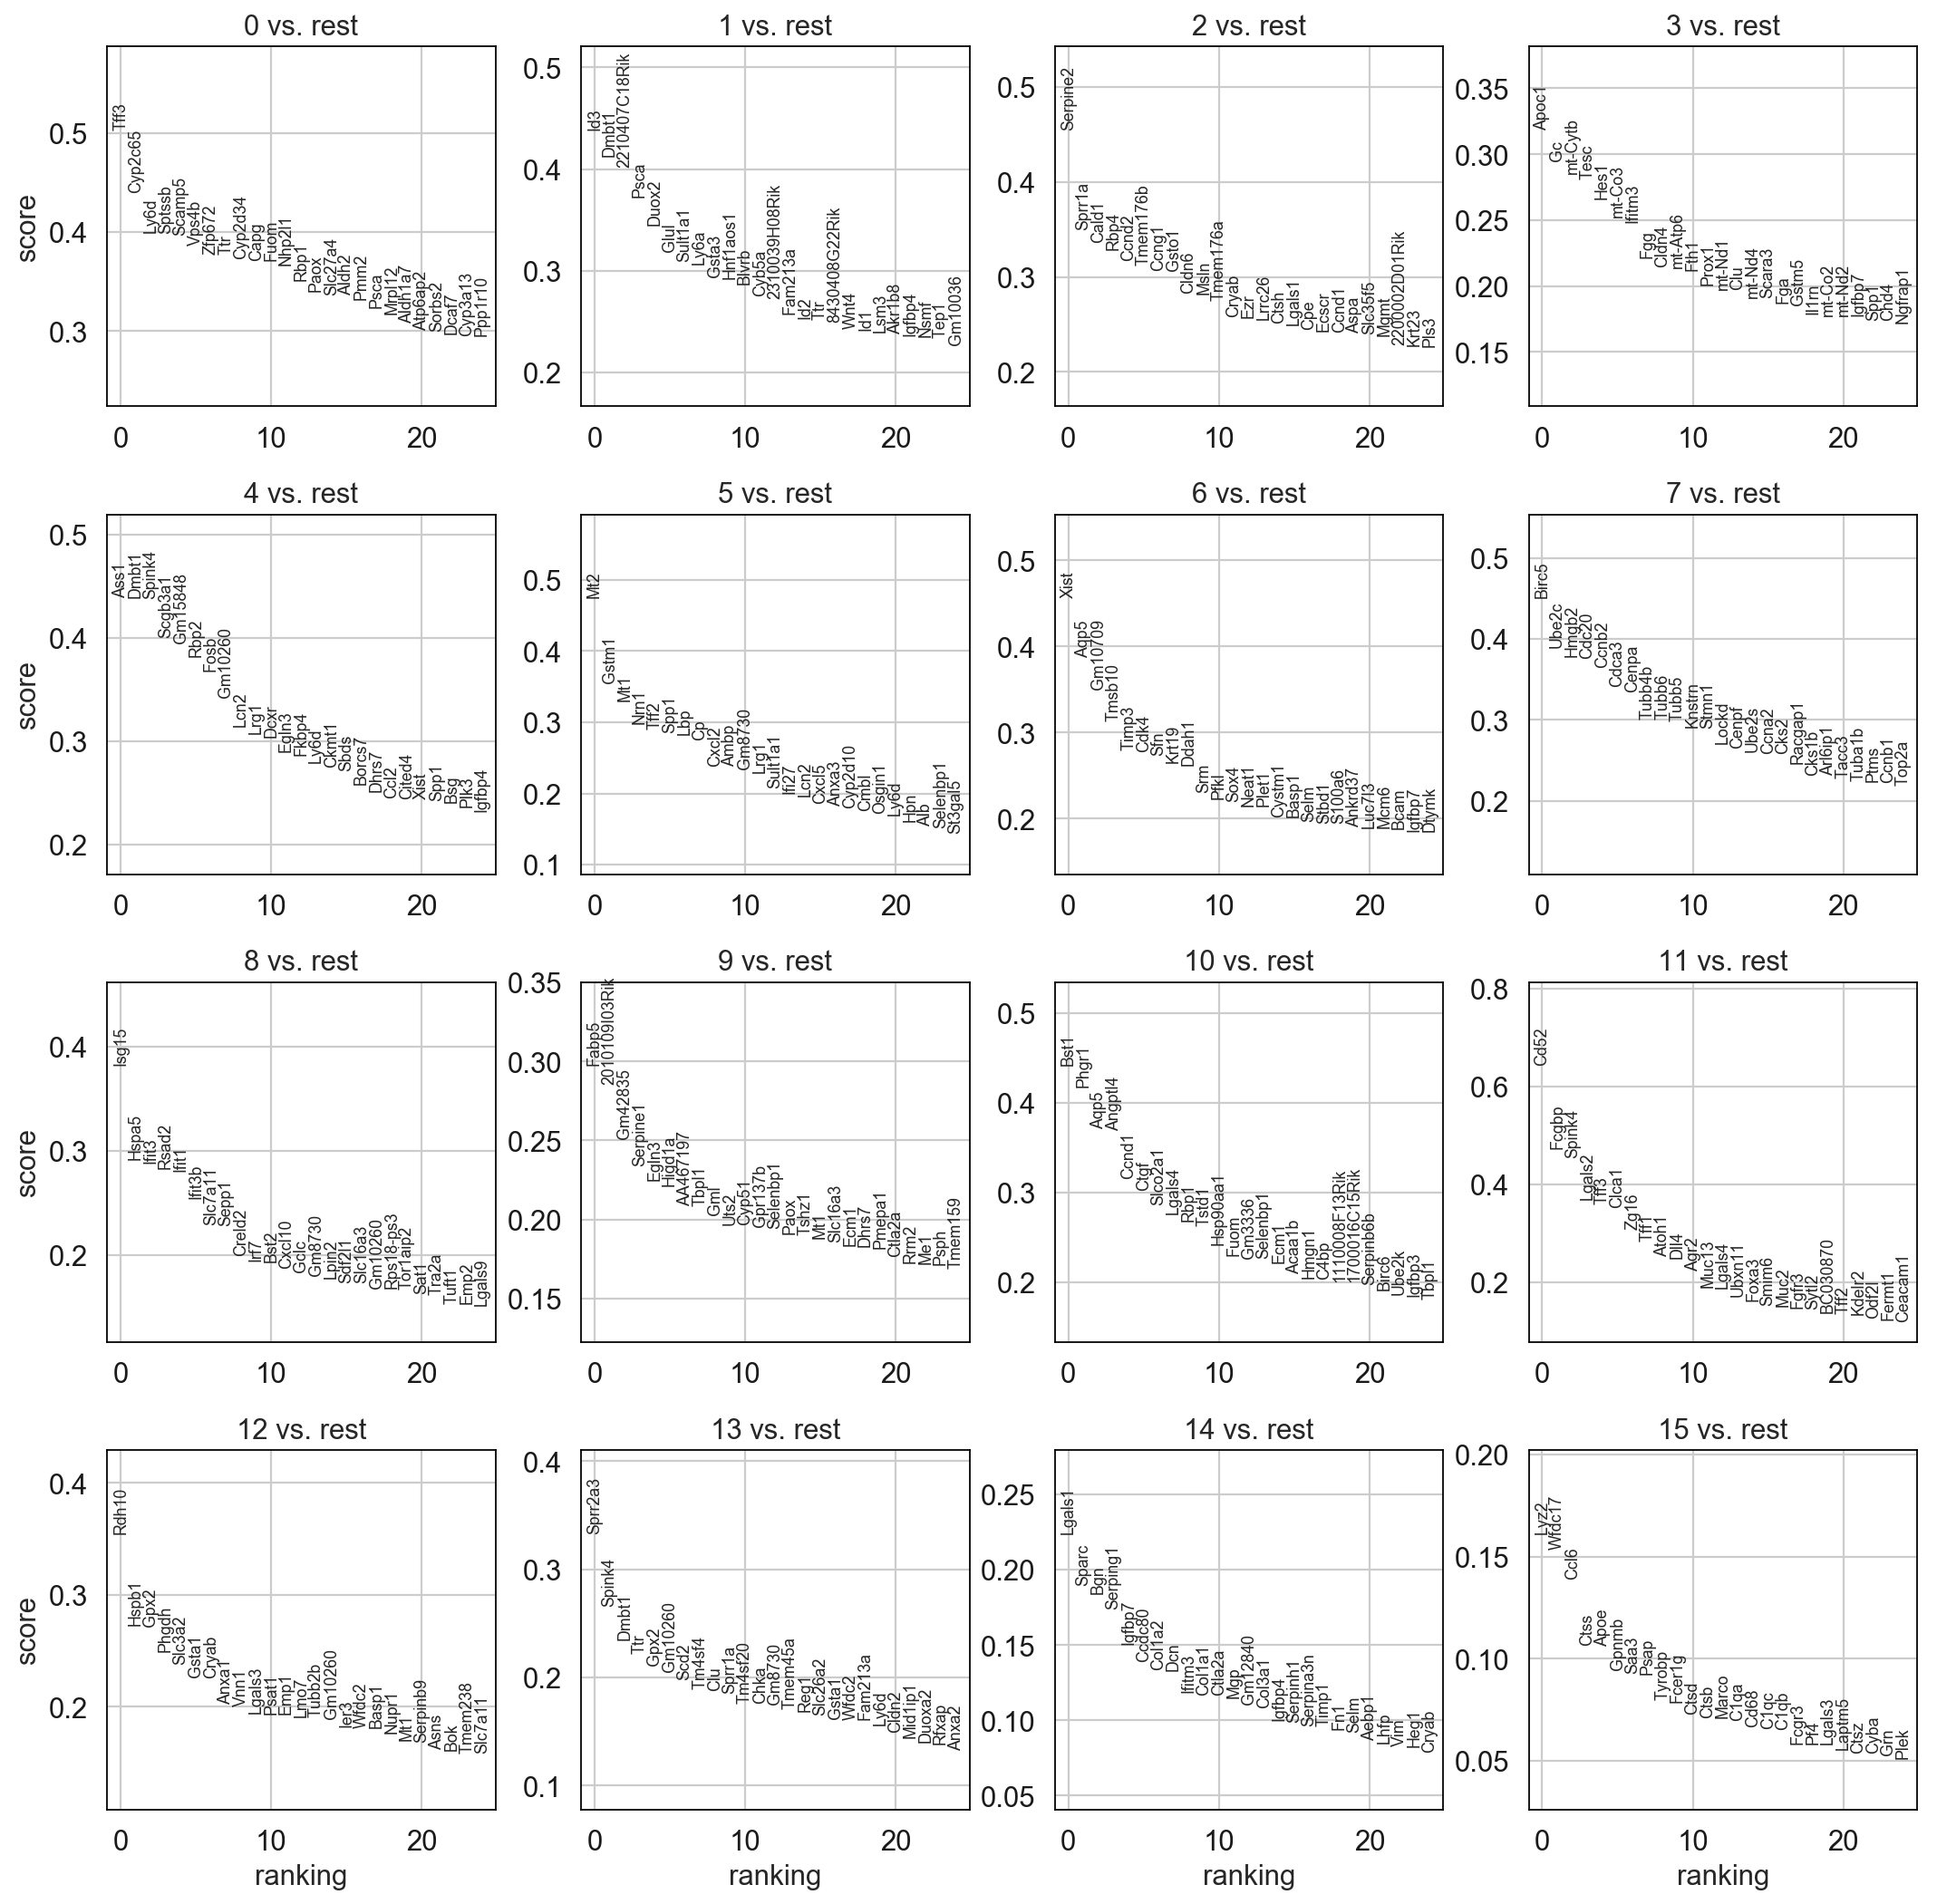

In [481]:
adata_copy = adata.copy()
sc.tl.rank_genes_groups(adata_copy, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata_copy, n_genes=25, sharey=False)

Let us also define a list of marker genes for later reference.

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [486]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0
0      Rbp1
1   Pglyrp1
2  AA467197
3     Gapdh
4     Phgr1

Get a table with the scores and groups.

In [488]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p
0      Rbp1  5.610478e-147
1   Pglyrp1  2.704756e-136
2  AA467197  7.757309e-129
3     Gapdh  7.290469e-117
4     Phgr1  8.530780e-115

Compare to a single cluster. 

ranking genes
    finished (0:00:01.80)


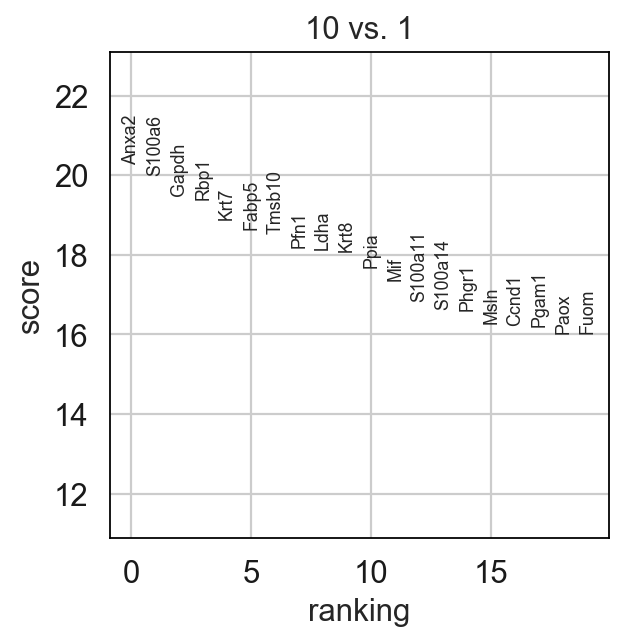

In [496]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain', groups=['10'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['10'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

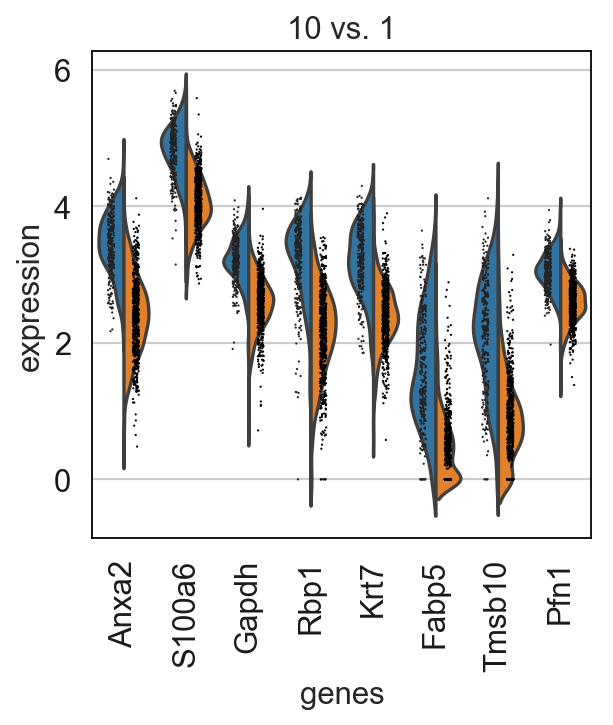

In [497]:
sc.pl.rank_genes_groups_violin(adata, groups='10', n_genes=8)

Reread the examples that were computed by comparing to the rest of the groups.

In [498]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='10', n_genes=8)

KeyError: 'rank_genes_groups'

If you want to compare a certain gene across groups, use the following.

In [499]:
#sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

Actually mark the cell types.

In [501]:
new_cluster_names = [
    '0', '1',
    '2', '3', 
    '4', '5',
    '6', '7', '8', '9', '10', '11',
    '12', '13', '14', '15']
adata.rename_categories('louvain', new_cluster_names)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:52.21)


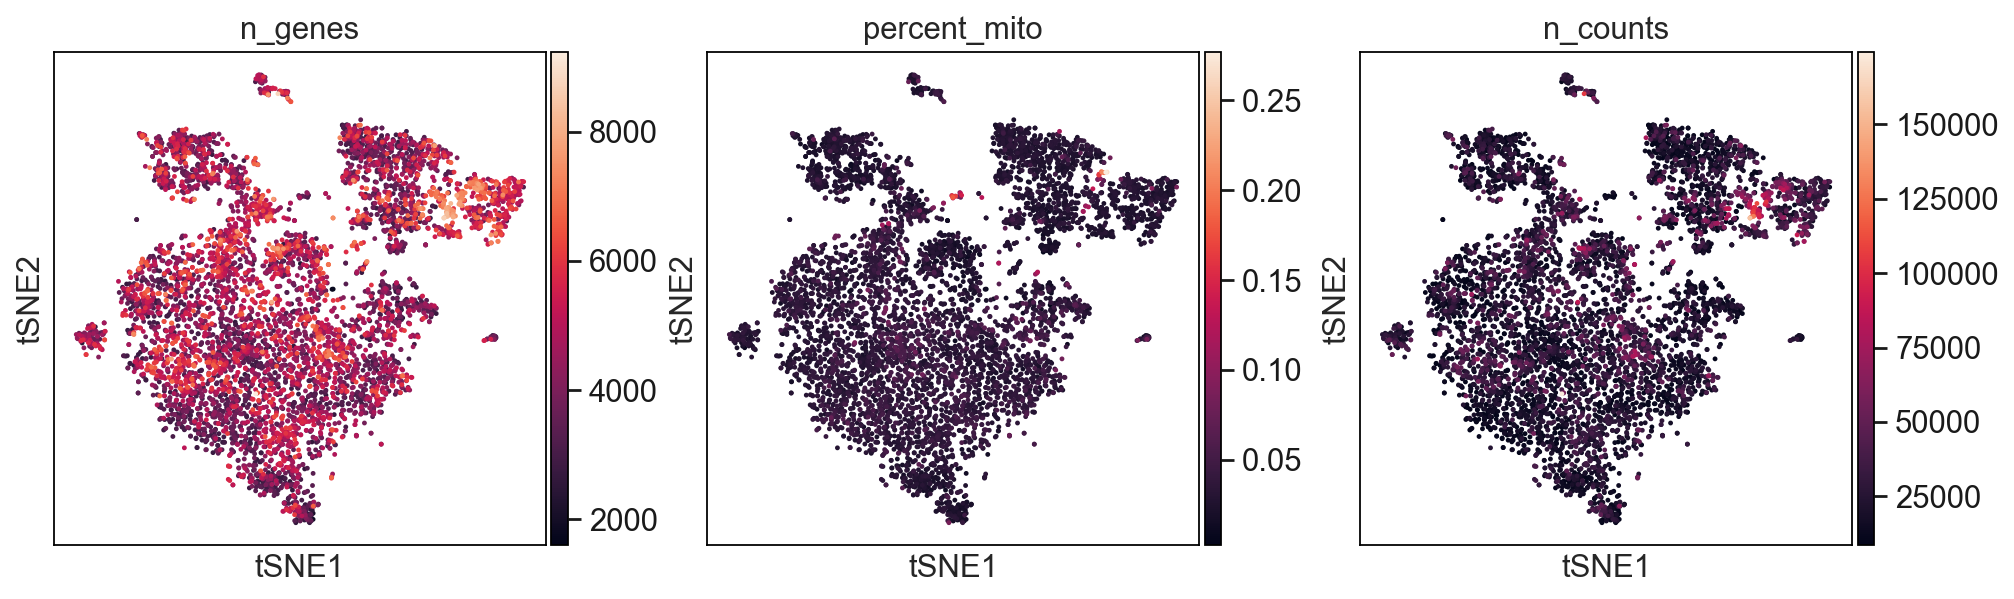

In [502]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=['n_genes', 'percent_mito', 'n_counts'])

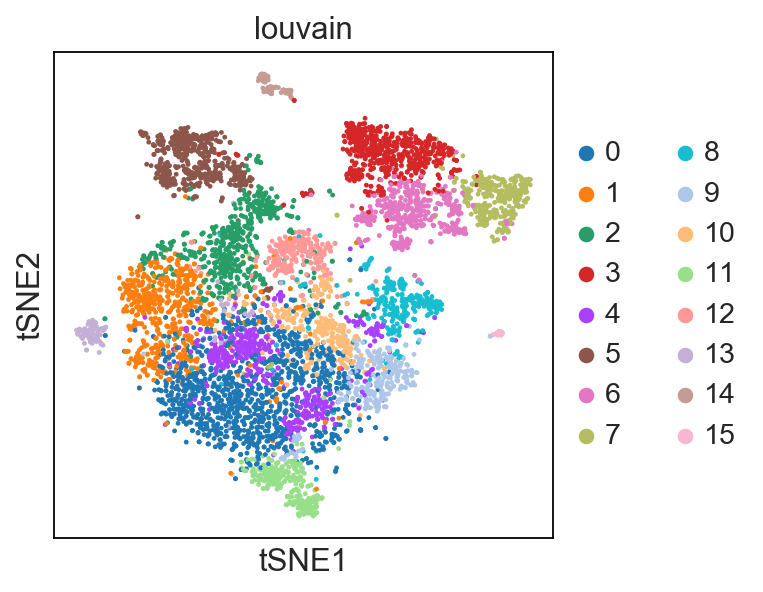

In [503]:
sc.pl.tsne(adata, color='louvain')

Now that we annotated the cell types, let us visualize the marker genes.

In [507]:
marker_genes = ["Hnf4a", "Alb", "Fah", "Krt8", "Krt18", "G6pc", "Sox9", "Krt7", "Krt19", "Epcam", "Onecut1", "Afp", "Xist"]
#, "Cyp7a1"]


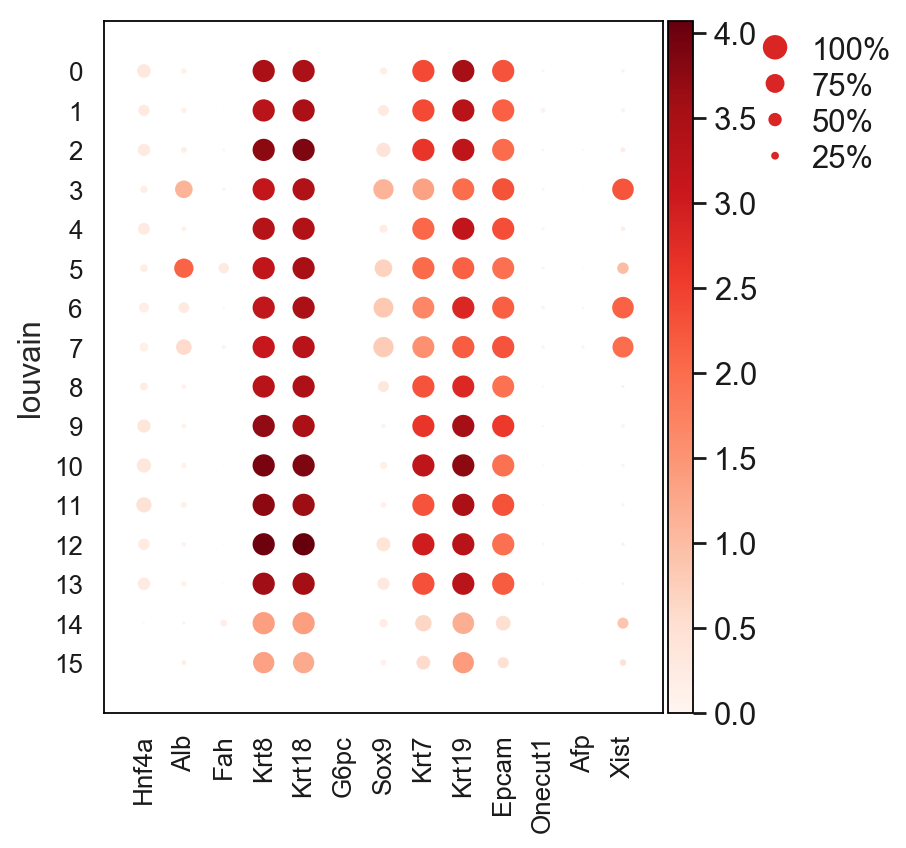

In [508]:
gs = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

There is also a very compact violin plot.

IndexError: list index out of range

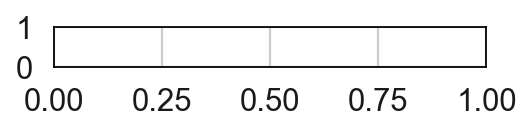

In [417]:
axs = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

See more examples using heatmaps and annotions of the plots [here](https://gist.github.com/fidelram/2289b7a8d6da055fb058ac9a79ed485c).

During the course of this analysis, the AnnData accumlated the following annotations.

In [311]:
adata

AnnData object with n_obs × n_vars = 5937 × 1349 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

In [51]:
adata.write(results_file)

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations.

In [52]:
adata.X = None
adata.write('./write/pbmc3k_withoutX.h5ad')

If you want to export to "csv", you have the following options:

In [53]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )